### Timeseries with statsmodels

Timeseries is usually a variable that is measured suequentially over time within fixed sampled interval, which results with data in a form of time series. One of the most important characteristics of a timeseries is that observations close together in time tend to be correlated (serially dependent). Based on this serial dependence basically we do all the forecasting, from classical SARIMA models to LSTM or LGBT. The most important concepts in timeseries are trend, seasonality, cycle, random walk and white noise.

Trend is systemic change in a time series that does not appear to be periodic. On contrary, seasonal variation is repeating pattern within each period (whatever sampling interval is, year, month, week, etc.) and it can repeat itself wihthin more sampling periods. Cycle is a pattern that does not correspond with some fix sampling interval but it has same repeating pattern (e.g. Milankovic's cycles, El Nino, business cycles...). White noise is pure randomness in the timeseries that is left when we remove all patterns (trend, seasonality, autocorellation). White noise should be distignishable from random walk which is defined here (link) and is not stationary process because it is not time indipendent. 

Let's see on an example and using very simple and helpfull package stats models how we can decompose a timeseries - how to extract trend and seasonality and how to check whether the timeseries is stationary. All this enables us the forecasting which is basically assumption that existing pattern of timeseries will continue (extrapolate) on some (at least) short future time.

We will use famous airpassanger data that could be found here (https://www.kaggle.com/rakannimer/air-passengers).

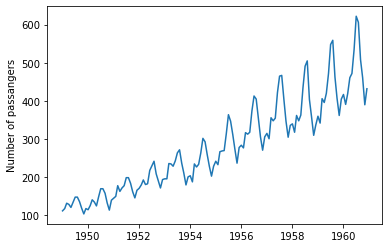

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
plt.plot(data)
plt.ylabel('Number of passangers');

Now we will decompose the timeseries to the trend and season (which will take input parameter for 12 months).
After that we will have to check the stationarity of residuals. A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time. So we will check the stationarity of our residuals, which would say us did trend and seasonality explained all the 'pattern' of our timeseries. 

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposition(timeseries, period):
    decomposition = seasonal_decompose(timeseries, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(10, 5))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

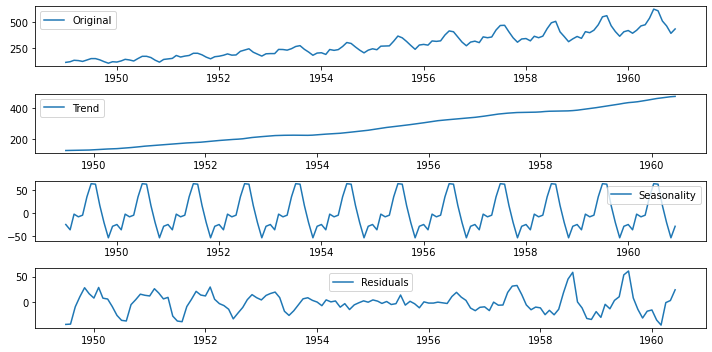

In [23]:
decomposition(data, 12)

We will use adfuller test which tells us whether the null hypothesis is true (timeseries is not stationary).

In [41]:
#Proveravamo stacionarnost vremenske serije
#Nulta hipoteza je da serija nije stacionarna. P nam govori o verovatnoci da je nulta hipoteza tacna
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(rolling).mean()
    rolstd = timeseries.rolling(rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title('Power consumption Old data')
    plt.xlabel('Time - periods(30s)')
    plt.ylabel('Power consumption in Watts')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput['p-value'] < 0.05:
        print('The timeseries is stationary at 95% level of confidence')
    else:
        print('The timeseries is not stationary at 95% level of confidence')

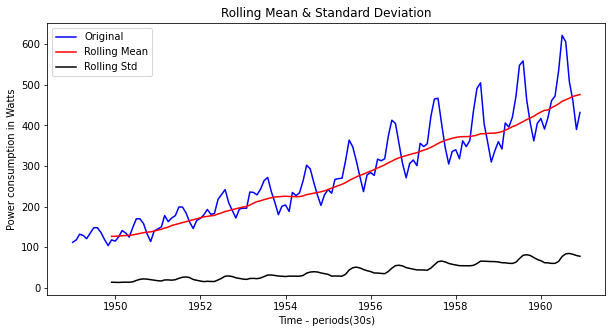

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The timesereis is not stationary at 95% level of confidence


In [40]:
test_stationarity(data, rolling=12)

As you can see from the results, residuals are not stationary, and you can see how standard deviation is increasing through the time, which means that there are also some parameters in timeseries that should be additionaly analysed. This leads as to the autoregression parameter and moving averages. Also, we obviously in this timeseries have multiplicative seasonal effect which means that seasonal effect is increasing as trend is increasing (Xt = mt (trend) * st (season) + zt (error). But let's pay attention to the autoregression.

Autoregression could easily be understood as autocorellation, i.e. correlation of the timeseries with itself in other time spots. For this we use correlogram which shows the correlation of deseasoned and detrended time series for different timespots. As parameter we can input the number of lags we want to calculate autocorrelation (in this data we have 144 time spots).

In [58]:
from statsmodels.tsa.stattools import acf, pacf
def correlogram_timeseries(timeseries, lags):
    warnings.filterwarnings('ignore')
    lag_acf = acf(timeseries, nlags=lags)
    plt.figure(figsize=(10,5))
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='blue')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='blue')
    plt.xlabel('Lags')
    plt.ylabel('Correlation')
    plt.title('Autocorrelation Function')
    
    #partial correlation
    lag_pacf = pacf(timeseries, nlags=lags, method='ols')
    plt.subplot(122) 
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='green')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='green')
    plt.xlabel('Lags')
    plt.title('Partial correlation Function')

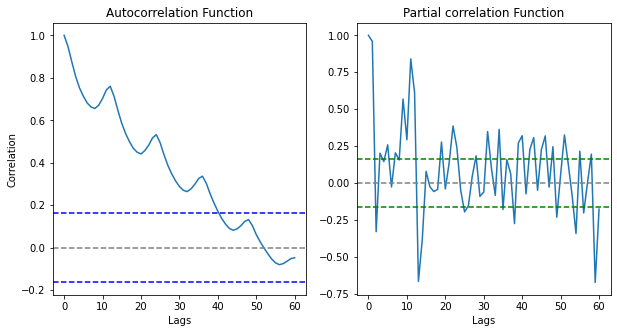

In [59]:
correlogram_timeseries(data, 60)

Usually, if the ACF and PACF are slowly decaying it means that we must do one more thing, it is differencing. This should help us to get to the stationarity of residuals, which in practice means that we explained all components of our timeseries and we completely 'have read' its pattern. Differencing substracts the two the most nearby time spots. 

In [64]:
def differencing(timeseries, second_order=False):
    diff = timeseries - timeseries.shift(1)
    diff=diff.dropna()
    print('Results of stationarity of the first ordered differencing')
    test_stationarity(diff)
    if second_order:
        diff_sec = diff - diff.shift(1)
        diff_sec=diff_sec.dropna()
        print('\n', 'Results of stationarity of the SECOND ordered differencing')
        test_stationarity(diff_sec)

Results of stationarity of the first ordered differencing


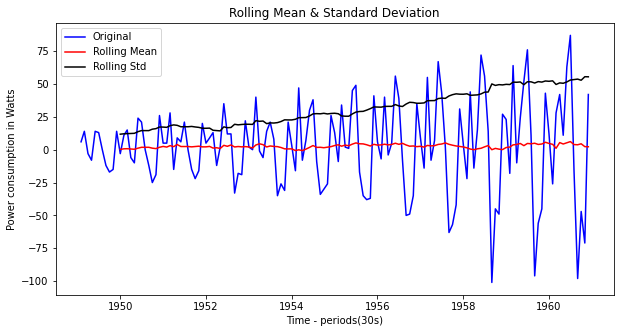

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The timeseries is not stationary at 95% level of confidence


In [65]:
differencing(data, False)

Here we can see that first order differencins is not yet lead to the stationary timeseries. We will try the second order differencing (difference of the already differenced timeseries).

Results of stationarity of the first ordered differencing


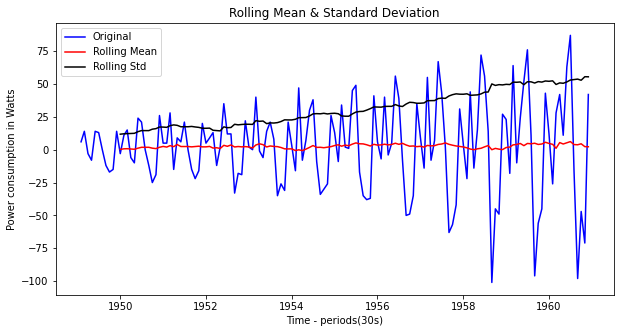

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The timeseries is not stationary at 95% level of confidence

 Results of stationarity of the SECOND ordered differencing


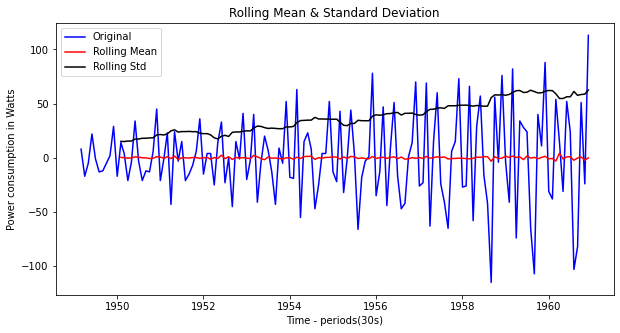

Results of Dickey-Fuller Test:
Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64
The timeseries is stationary at 95% level of confidence


In [66]:
differencing(data, True)

Finally! We got the stationary residuals. The mean and standard deviation of the residuals do not vary through time. This means that our I parameter in ARIMA should be 2. But what about AR and MA? As you guess, AR is autoregressive parameter, while MA is moving average. We can conclude what parameters to take reading the correlograms above. Accepted rule is that we have sinusoidal patternt of ACF and jumps in PACF it should be AR = 2, which means that our forecasted timespot will take this formula:
Yt = b0 + b1 * Yt-1 + b2 * Yt-2 + wt (wt = white noise). 

### SARIMAX
Now we will make, using simple stats models package, very simple model of SARIMAX, having knowledge about all parameters of our data. This is basically very similar to ARIMA, but just with seasonal component. X in name also provides the possibilty to include the exogenous predictor which in this case does not exists. We will make small train test split function and than make a predictions. We will then make a function that could make forecast for the desired number of lags. 

In [69]:
from statsmodels.tsa.arima_model import ARIMA
def train_test_split(timeseries, lags_for_prediction=12):
    split=len(timeseries)-lags_for_prediction
    train=timeseries[:split]
    test=timeseries[split:]
    return train, test

In [95]:
train_series, test_series = train_test_split(data, 12)

Our diferencing parameter must be 2, as well as AR parameter. We do not have space here to explain MA parameter, so we wiil just make 1.

In [123]:
#p - AR (autocorrelation parameter)
#d - Differencing parameter
#q - MA (moving average parameter)

def forecasting (p,d,q, season, lags_for_forecast):

    model = sm.tsa.statespace.SARIMAX(train_series, order=(p,d,q), seasonal_order=(p,d,q,season),
                                             simple_differencing=0, #if True  time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
    fitted = model.fit(disp=-1)  

    # Forecast
    forecast = fitted.forecast(lags_for_forecast)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train_series, color='blue', label='train')
    plt.plot(test_series, color='green', label='test', alpha=0.6)
    plt.plot(forecast, color='red', label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    RSS=np.sqrt(sum(forecast.values-timeseries_test.values.reshape(-1))**2)/lags_for_forecast
    print("\n", '\033[1m' +'Root Squared Error (RSS) of SARIMAX model(p,d,q)(p,d,q,s)' + '\033[0m',order,seasonal_order,':', round(RSS, 3),"\n")
    print(fitted.summary())

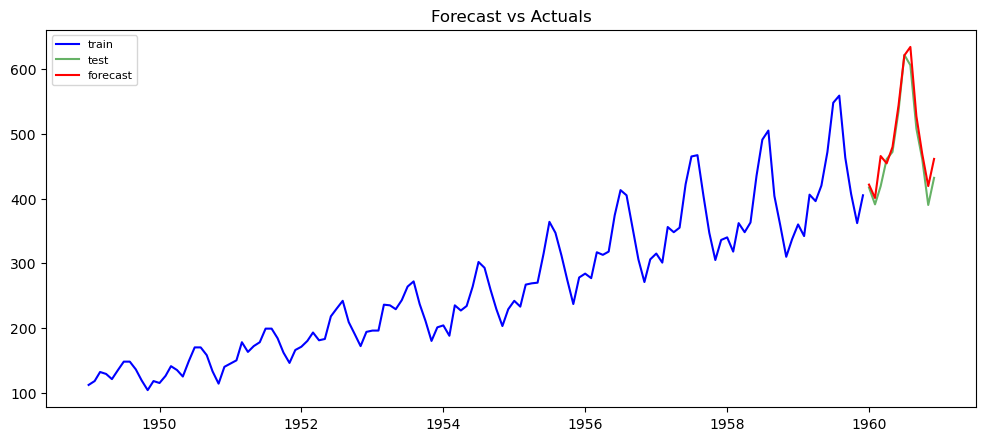


 Root Squared Error (RSS) of SARIMAX model(p,d,q)(p,d,q,s) (2, 2, 1) (2, 1, 2, 12) : 15.321 

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 2, 1)x(2, 2, 1, 12)   Log Likelihood                -407.554
Date:                            Mon, 31 Jan 2022   AIC                            829.108
Time:                                    12:21:23   BIC                            847.752
Sample:                                01-01-1949   HQIC                           836.665
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.33

In [124]:
forecasting (2,2,1, 12, 12)

Congratulations! This was the basic univariate timeseries modelling. This could be quite efficient model for univariate timeseries. But also have in mind that you can also use more advanced techniques, including modeling with exogenous predictors, using Long-Short term Neural Networks (LSTM) and also you could use ensemble methods such as Light Gradient Boosting or other techniques that relies on decision trees.